In [ ]:
# Link to paper: https://arxiv.org/pdf/1708.05031.pdf
# Adapted from https://github.com/hexiangnan/neural_collaborative_filtering/blob/master/NeuMF.py

import tensorflow as tf
from tensorflow.keras import Model, layers, models, initializers, regularizers, optimizers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import heapq
import os
import requests
import io
from zipfile import ZipFile

In [ ]:
url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
r = requests.get(url)
z = ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv('./ml-100k/u.data', '\t', names=names)
num_users = len(data.user_id.unique())
num_items = len(data.item_id.unique())

data = data.sample(frac=1)

train_data = []
test_data = {}

for row in data.itertuples():
  u, i, t = row[1], row[2], row[4]
  train_data.append((u, i, t))
  if u not in test_data or t > test_data[u][-1]:
    test_data[u] = (u, i, t)

for i in test_data.values():
  train_data.remove(i)

train_data = pd.DataFrame(train_data, columns=['user_id', 'item_id', 'timestamp'])
test_data = pd.DataFrame(test_data.values(), columns=['user_id', 'item_id', 'timestamp'])

train_negative_instances = {u : [i for i in range(num_items)] for u in range(num_users)}
test_negative_instances = {u : [i for i in range(num_items)] for u in range(num_users)}

for row in train_data.itertuples():
  user_id, item_id = row[1], row[2]
  train_negative_instances[user_id-1].remove(item_id-1)

for row in test_data.itertuples():
  user_id, item_id = row[1], row[2]
  test_negative_instances[user_id-1].remove(item_id-1)

def get_dataset(data, negative_instances, num_negatives=4):
  user_input, item_input, label = [], [], []
  for row in data.itertuples():
    user_id, item_id = row[1], row[2]
    user_input.append(user_id-1)
    item_input.append(item_id-1)
    label.append(1)

    i = random.sample(negative_instances[user_id-1], num_negatives)
    user_input.extend([user_id-1]*num_negatives)
    item_input.extend(i)
    label.extend([0]*num_negatives)

  return np.array([user_input, item_input]).T, np.array(label)

In [ ]:
class GMF(Model):
  def __init__(self, num_users, num_items, embedding_dim):
    super().__init__()
    self.embedding_dim = embedding_dim
    self.user_embedding = layers.Embedding(num_users, embedding_dim,
                                           embeddings_regularizer=regularizers.l2(1e-5))
    
    self.item_embedding = layers.Embedding(num_items, embedding_dim,
                                           embeddings_regularizer=regularizers.l2(1e-5))
    
    self.out = layers.Dense(1, activation='sigmoid')

  def call(self, inputs):
    p = self.user_embedding(inputs[:, 0])
    q = self.item_embedding(inputs[:, 1])
    outputs = self.out(p * q)
    return outputs

gmf = GMF(num_users, num_items, 10)

gmf.compile(
    optimizer=optimizers.Adam(0.001),
    loss='binary_crossentropy'
)

In [ ]:
gmf_loss = []

for _ in range(10):
  x_train, y_train = get_dataset(train_data, train_negative_instances)
  gmf_history = gmf.fit(
      x=x_train,
      y=y_train,
      batch_size=256,
      epochs=1
  )

  gmf_loss.append(gmf_history.history["loss"][0])

1935/1935 [==============================] - 3s 1ms/step - loss: 0.2755


In [ ]:
class MLP(Model):
  def __init__(self, num_users, num_items, embedding_dim):
    super().__init__()
    self.embedding_dim = embedding_dim
    self.user_embedding = layers.Embedding(num_users, embedding_dim,
                                           embeddings_regularizer=regularizers.l2(1e-5))
    
    self.item_embedding = layers.Embedding(num_items, embedding_dim,
                                           embeddings_regularizer=regularizers.l2(1e-5))

    self.layer_dims = [64,32,16,8]
    self.mlp = models.Sequential()
    for layer_dim in self.layer_dims:
      self.mlp.add(layers.Dense(layer_dim, activation='relu',
                                kernel_regularizer=regularizers.l2(1e-5)))
    
    self.out = layers.Dense(1, activation='sigmoid')
   
  def call(self, inputs):
    p = self.user_embedding(inputs[:, 0])
    q = self.item_embedding(inputs[:, 1])
    concat = tf.concat([p, q], axis=1)
    outputs = self.out(self.mlp(concat))
    return outputs

mlp = MLP(num_users, num_items, 32)

mlp.compile(
    optimizer=optimizers.Adam(0.001),
    loss='binary_crossentropy'
)

In [ ]:
mlp_loss = []

for _ in range(10):
  x_train, y_train = get_dataset(train_data, train_negative_instances)
  mlp_history = mlp.fit(
      x=x_train,
      y=y_train,
      batch_size=256,
      epochs=1
  )

  mlp_loss.append(mlp_history.history["loss"][0])

1935/1935 [==============================] - 5s 3ms/step - loss: 0.2495


In [ ]:
class NeuMF(Model):
  def __init__(self, gmf, mlp):
    super().__init__()
    self.gmf_user_embedding = layers.Embedding(num_users, gmf.embedding_dim,
                                               embeddings_initializer=initializers.constant(gmf.user_embedding.get_weights()),
                                               embeddings_regularizer=regularizers.l2(1e-5))
    
    self.mlp_user_embedding = layers.Embedding(num_users, mlp.embedding_dim,
                                               embeddings_initializer=initializers.constant(mlp.user_embedding.get_weights()),
                                               embeddings_regularizer=regularizers.l2(1e-5))
    
    self.gmf_item_embedding = layers.Embedding(num_items, gmf.embedding_dim,
                                               embeddings_initializer=initializers.constant(gmf.item_embedding.get_weights()),
                                               embeddings_regularizer=regularizers.l2(1e-5))
    
    self.mlp_item_embedding = layers.Embedding(num_items, mlp.embedding_dim,
                                               embeddings_initializer=initializers.constant(mlp.item_embedding.get_weights()),
                                               embeddings_regularizer=regularizers.l2(1e-5))
    
    self.mlp_layers = models.Sequential()
    for idx, layer_dim in enumerate(mlp.layer_dims):
      kernel_init = initializers.constant(mlp.mlp.get_layer(index=idx).get_weights()[0])
      bias_init = initializers.constant(mlp.mlp.get_layer(index=idx).get_weights()[1])
      self.mlp_layers.add(layers.Dense(layer_dim, activation='relu',
                                       kernel_initializer=kernel_init,
                                       bias_initializer=bias_init,
                                       kernel_regularizer=regularizers.l2(1e-5)))
    
    new_weights = initializers.constant(tf.concat([gmf.out.get_weights()[0], mlp.out.get_weights()[0]], axis=0) * 0.5)
    new_bias = initializers.constant((gmf.out.get_weights()[1] + mlp.out.get_weights()[1]) * 0.5)
    self.out = layers.Dense(1, activation='sigmoid', kernel_initializer=new_weights, bias_initializer=new_bias)
    
  def call(self, inputs):
    gmf_p = self.gmf_user_embedding(inputs[:, 0])
    gmf_q = self.gmf_item_embedding(inputs[:, 1])
    mlp_p = self.mlp_user_embedding(inputs[:, 0])
    mlp_q = self.mlp_item_embedding(inputs[:, 1])

    gmf_out = gmf_p * gmf_q
    mlp_out = self.mlp_layers(tf.concat([mlp_p, mlp_q], axis=1))

    concat = tf.concat([gmf_out, mlp_out], axis=1)
    outputs = self.out(concat)
    return outputs

model = NeuMF(gmf, mlp)

model.compile(
    optimizer=optimizers.Adam(0.001),
    loss='binary_crossentropy'
)

In [ ]:
loss = []

for _ in range(10):
  x_train, y_train = get_dataset(train_data, train_negative_instances)
  history = model.fit(
      x=x_train,
      y=y_train,
      batch_size=256,
      epochs=1
  )

  loss.append(history.history["loss"][0])

1935/1935 [==============================] - 6s 3ms/step - loss: 0.2160


In [ ]:
def hit_ratio(rank_list, item):
  if item in rank_list:
    return 1
  return 0

def ndcg(rank_list, item):
  for i in range(len(rank_list)):
    if rank_list[i] == item:
      return math.log(2) / math.log(i+2)
  return 0

def evaluate():
  hit_ratios, ndcgs = [], []
  for row in test_data.itertuples():
    users, items = [], []
    u, i = row[1]-1, row[2]-1

    users.append(u)
    items.append(i)

    users.extend([u]*100)
    items.extend(random.sample(test_negative_instances[u], 100))

    predictions = model(np.array([users, items]).T)
    map_item_prediction = {item : predictions[idx] for idx, item in enumerate(items)}
    rank_list = heapq.nlargest(10, map_item_prediction, map_item_prediction.get)

    hit_ratios.append(hit_ratio(rank_list, i))
    ndcgs.append(ndcg(rank_list, i))
  
  print(f'HR: {np.mean(hit_ratios)}, NDCG: {np.mean(ndcgs)}')

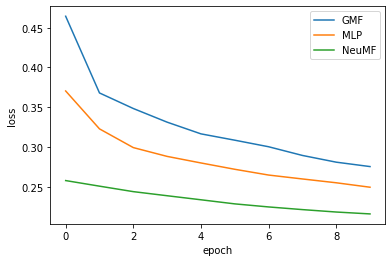

HR: 0.48886532343584305, NDCG: 0.23844318782177581


In [ ]:
plt.plot(gmf_loss)
plt.plot(mlp_loss)
plt.plot(loss)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["GMF", "MLP", "NeuMF"], loc="upper right")
plt.show()

evaluate()